**X-Ray classification**

**Try all parts for 20 epochs - with deep data augmentation**

Notes:

* **Metrics not exported**


1. Run evaluate to train and not test, Fix pending
2. Didn't delete model after fit, fit afresh new dataset, Fix pending

Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. 

You must use at least **2 different architectures**,
* one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and 
* one with a popular CNN pre-trained CNN model (e.g., VGG-19, ResNet, etc.). 

Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found [here](https://stanfordmlgroup.github.io/competitions/mura/). To download the dataset you must fill out a form, so complete this action as soon as possible.

# Libraries

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.image as mpimg
# from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import random, os
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
import gc
# from skimage.transform import resize
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

from sklearn.metrics import f1_score, recall_score, precision_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
! pip install -q -U keras-tuner
import keras_tuner as kt

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import lib.data_loader as data_loader
import lib.plot_learning_curves as plot_learning_curves
import models.base_model as base_model
import models.densenet as densenet
import models.resnet as resnet
print("Tensorflow version " + tf.__version__)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version 2.4.0


In [29]:
# mount data from gdrive and change directory
data_path = 'data/MURA-v1.1/'
directory = 'data/'
! pwd

/tf


# Data  munging

In [30]:
train, test, bodyparts, bodyparts_train_validation_dict, train_generators, valid_generators, test_generators = data_loader.data_loader(data_augmentation='deep_augment')


Import train and test data


Create dictionary for training and validation set per body part

Doing a light data augmentation

Create dictionary for training, validation and test set per body part

Found 1646 validated image filenames.
Found 179 validated image filenames.
Found 301 validated image filenames.
Found 4598 validated image filenames.
Found 508 validated image filenames.
Found 461 validated image filenames.
Found 1143 validated image filenames.
Found 129 validated image filenames.
Found 288 validated image filenames.
Found 4432 validated image filenames.
Found 499 validated image filenames.
Found 465 validated image filenames.
Found 7507 validated image filenames.
Found 872 validated image filenames.
Found 563 validated image filenames.
Found 8745 validated image filenames.
Found 1007 validated image filenames.
Found 659 validated image filenames.
Found 4988 validated image filenames.
Found 555 validated image filenames.
Found 460 validated image filenames.
Data munging com

# CNN  with data augmentation

In [ ]:
def build_model(input_shape,
                conv_layers,
                conv_activation,
                conv_dropout,
                units,
                output_activation,
                optimizer,
                loss,
                metrics,
                verbose=1):
    
    np.random.seed(1234) # Define the seed for numpy to have reproducible experiments.
    set_seed(9876) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**(i+1)),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Add a dense before output layer and drop out
    x = tf.keras.layers.Dense(units=100,
                              activation='relu',
                              name='Dense-1')(x)

    x = tf.keras.layers.Dropout(rate= 0.2, 
                                name='Dropout-{0:d}'.format(conv_layers + 1))(x)
    # Define the output layer.
    output = Dense(
        units=units,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, 
                  outputs=output)
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    # print summary and architecture
    model.summary()

    return model

## Build

## Train

In [5]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=4,
                                             verbose=1)    
def train_model(model, bodypart):
    
    validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
    print("Using validation_steps = %d" % validation_steps)
    steps_per_epoch = math.ceil(train_generators[bodypart].n / (8*train_generators[bodypart].batch_size))
    print("Using steps_per_epoch = %d" % steps_per_epoch)

    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=20,
                        verbose=1,
                        callbacks=[callbacks]
    )
    return history

In [ ]:
def eval_func(y_true, y_prob):
    """
    A function calculating the different evaluation metrics on the test set.
    Converts prediction probabilities y_prob to predicted labels y_pred
    """
    y_pred = np.array([1 if prob >= 0.5 else 0 for prob in y_prob])
    y_true = np.array(y_true)

    print(f"Test accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)} %")
    print(f"Test F1 score: {round(f1_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Precision score: {round(precision_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Recall score: {round(recall_score(y_true, y_pred)*100, 2)} %")

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [8]:
histories_cnn = {}

for bodypart in set(train.bodypart):
    print('-----------')
    print(bodypart)
    model = build_model(input_shape = (320,320,3),
                        conv_layers = 4,
                        conv_activation = 'relu',
                        conv_dropout = 0.2,
                        units = 1,
                        output_activation = 'sigmoid',
                        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                        loss = 'binary_crossentropy',
                        metrics = ['binary_accuracy'])
    histories_cnn[bodypart] = train_model(model, 
                              bodypart)
    print('\nSave training history\n')
    import json
    with open("data/history/model_cnn_20epochs_deep_augment_"+bodypart+".json", "w") as file:
        json.dump(histories_cnn[bodypart].history, file)
        print('\nSave model\n')
    print('\nSave model\n')
    model.save("data/models/model_cnn_20epochs_deep_augment_"+bodypart)
    model.save("data/models/model_cnn_20epochs_deep_augment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    print('evaluate_test_generators')
    model.evaluate(test_generators[bodypart], verbose=1)
    print('evaluate_train_generators')
    model.evaluate(train_generators[bodypart], verbose=1)
    print('evaluate_valid_generators')
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

-----------
XR_HUMERUS
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 80, 80, 32)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 80

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
5/5 [==============================] - 32s 5s/step - loss: 1.2572 - binary_accuracy: 0.4956 - val_loss: 0.6931 - val_binary_accuracy: 0.4692
Epoch 2/20
5/5 [==============================] - 23s 4s/step - loss: 0.6973 - binary_accuracy: 0.4937 - val_loss: 0.6930 - val_binary_accuracy: 0.5308
Epoch 3/20
5/5 [==============================] - 22s 4s/step - loss: 0.6900 - binary_accuracy: 0.5896 - val_loss: 0.6927 - val_binary_accuracy: 0.5308
Epoch 4/20
5/5 [==============================] - 21s 4s/step - loss: 0.6856 - binary_accuracy: 0.5830 - val_loss: 0.6926 - val_binary_accuracy: 0.5308
Epoch 5/20
5/5 [==============================] - 22s 4s/step - loss: 0.6655 - binary_accuracy: 0.6766 - val_loss: 0.6944 - val_binary_accuracy: 0.5308
Epoch 6/20
5/5 [==============================] - 21s 4s/step - loss: 0.6864 - binary_accuracy: 0.5298 - val_loss: 0.6917 - val_binary_accuracy: 0.5308
Epoch 7/20
5/5 [==============================] - 22s 4s/step - loss: 0.6928 - binary_ac

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


36/36 [==============================] - 90s 2s/step - loss: 0.6926 - binary_accuracy: 0.5342
evaluate_valid_generators
5/5 [==============================] - 3s 449ms/step - loss: 0.6924 - binary_accuracy: 0.5615
Delete model
-----------
XR_HAND
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
____________

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 9s 570ms/step - loss: 0.6595 - binary_accuracy: 0.5891
evaluate_train_generators


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


157/157 [==============================] - 353s 2s/step - loss: 0.5835 - binary_accuracy: 0.7369
evaluate_valid_generators
17/17 [==============================] - 11s 584ms/step - loss: 0.6207 - binary_accuracy: 0.6895
Delete model
-----------
XR_ELBOW
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_____

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


15/15 [==============================] - 9s 599ms/step - loss: 0.7209 - binary_accuracy: 0.5054
evaluate_train_generators


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


140/140 [==============================] - 377s 3s/step - loss: 0.6616 - binary_accuracy: 0.5974
evaluate_valid_generators
15/15 [==============================] - 11s 727ms/step - loss: 0.7057 - binary_accuracy: 0.5530
Delete model
-----------
XR_FOREARM
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
___

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 11s 1s/step - loss: 0.8267 - binary_accuracy: 0.4983
evaluate_train_generators


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


52/52 [==============================] - 168s 3s/step - loss: 0.6894 - binary_accuracy: 0.6372
evaluate_valid_generators
6/6 [==============================] - 6s 842ms/step - loss: 0.6916 - binary_accuracy: 0.6432
Delete model
-----------
XR_FINGER
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_________

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


144/144 [==============================] - 423s 3s/step - loss: 0.6237 - binary_accuracy: 0.6327
evaluate_valid_generators
16/16 [==============================] - 12s 729ms/step - loss: 0.6020 - binary_accuracy: 0.6746
Delete model
-----------
XR_SHOULDER
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
__

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


236/236 [==============================] - 731s 3s/step - loss: 0.6840 - binary_accuracy: 0.5582
evaluate_valid_generators
27/27 [==============================] - 21s 737ms/step - loss: 0.6889 - binary_accuracy: 0.5261
Delete model
-----------
XR_WRIST
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_____

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


275/275 [==============================] - 805s 3s/step - loss: 0.6268 - binary_accuracy: 0.6366
evaluate_valid_generators
31/31 [==============================] - 24s 766ms/step - loss: 0.6345 - binary_accuracy: 0.6208
Delete model


In [9]:
from importlib import reload
reload(plot_learning_curves)

<module 'lib.plot_learning_curves' from '/tf/lib/plot_learning_curves.py'>

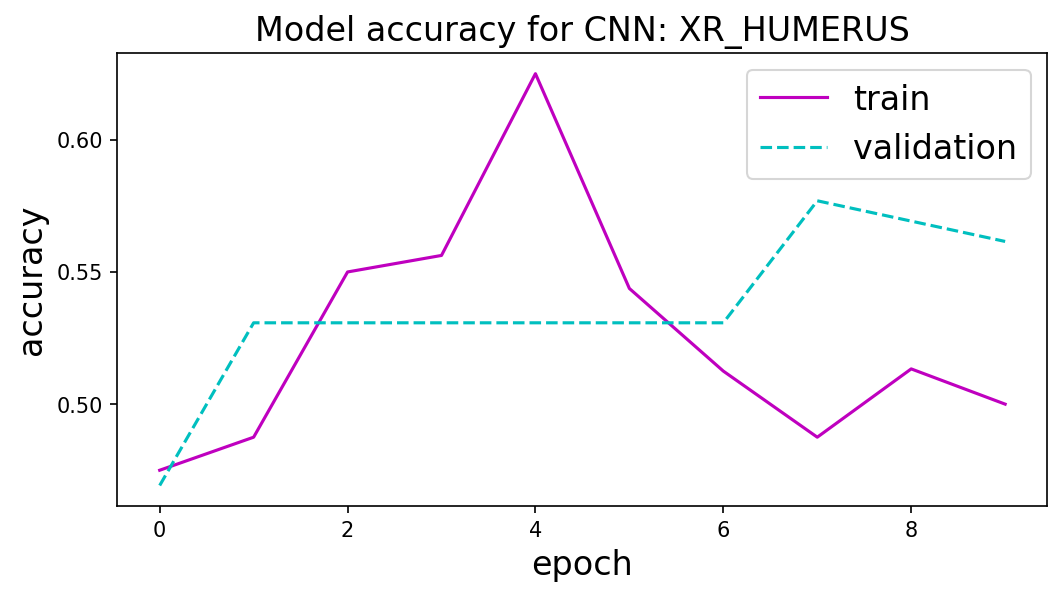

<Figure size 432x288 with 0 Axes>

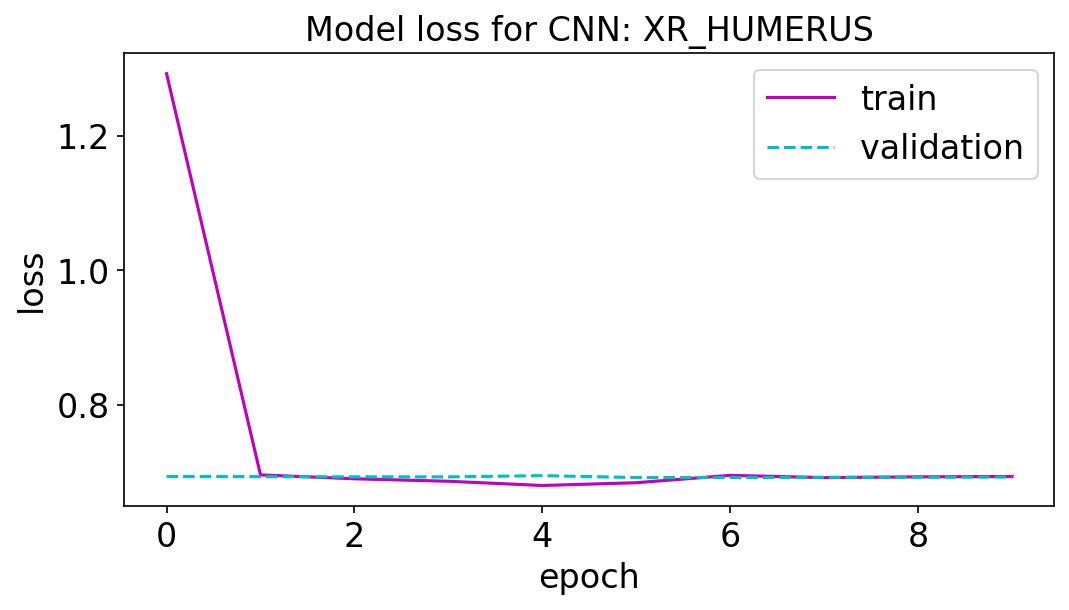

<Figure size 432x288 with 0 Axes>

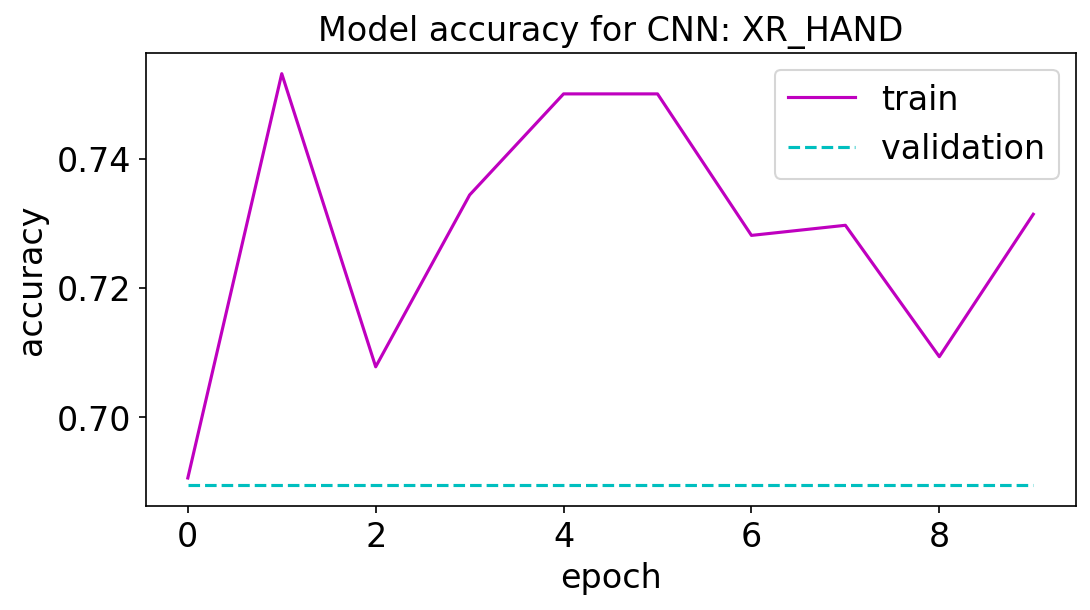

<Figure size 432x288 with 0 Axes>

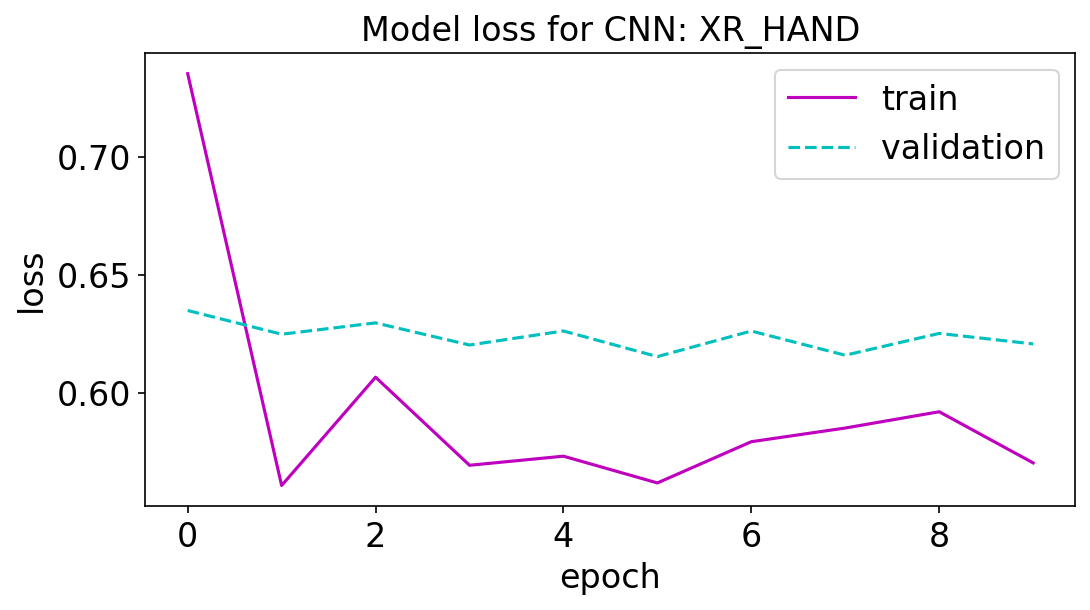

<Figure size 432x288 with 0 Axes>

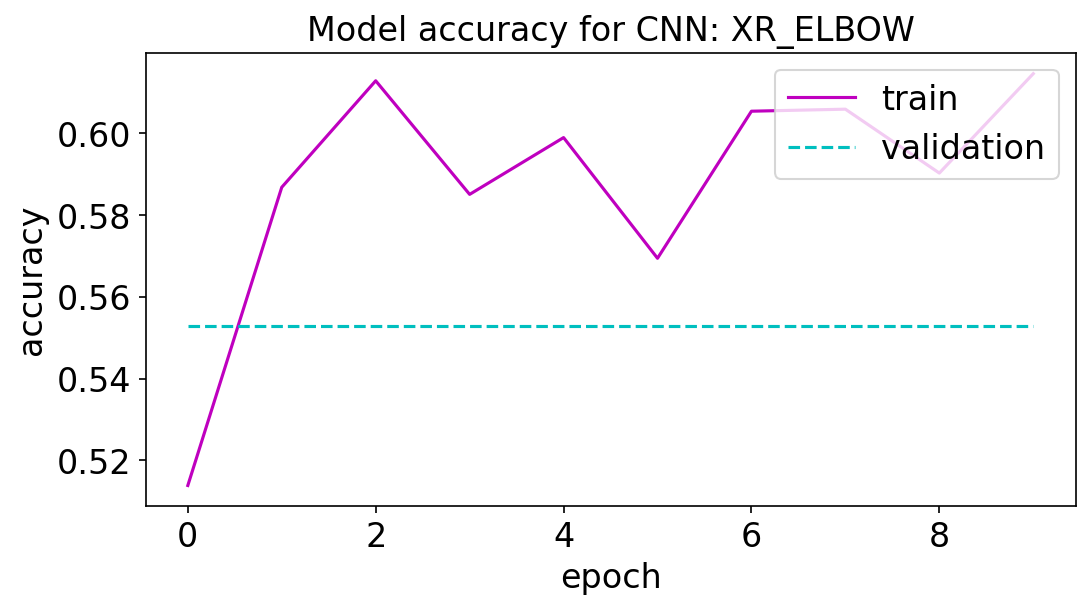

<Figure size 432x288 with 0 Axes>

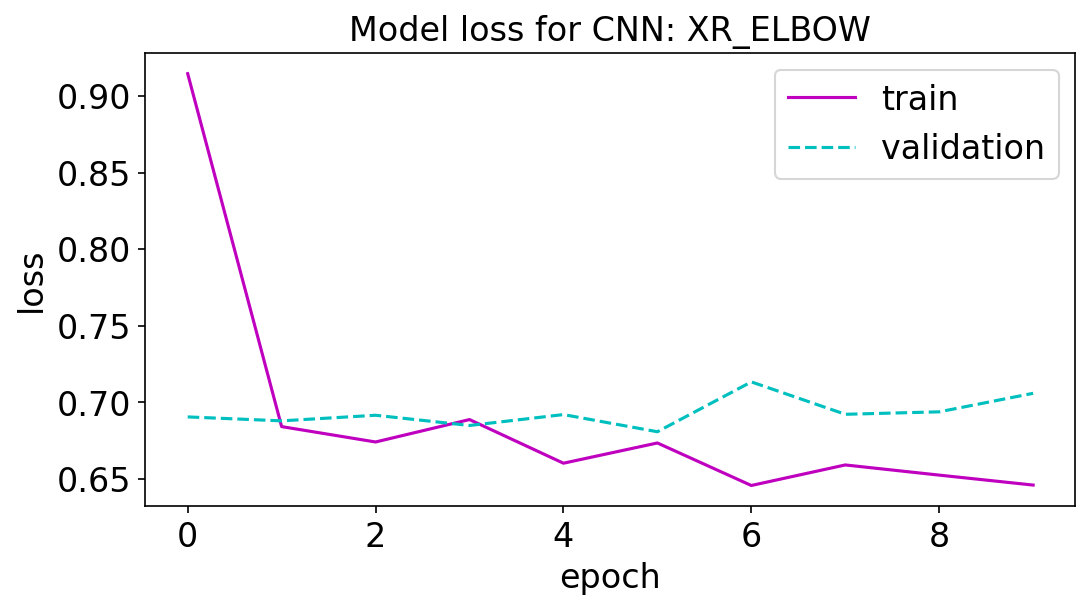

<Figure size 432x288 with 0 Axes>

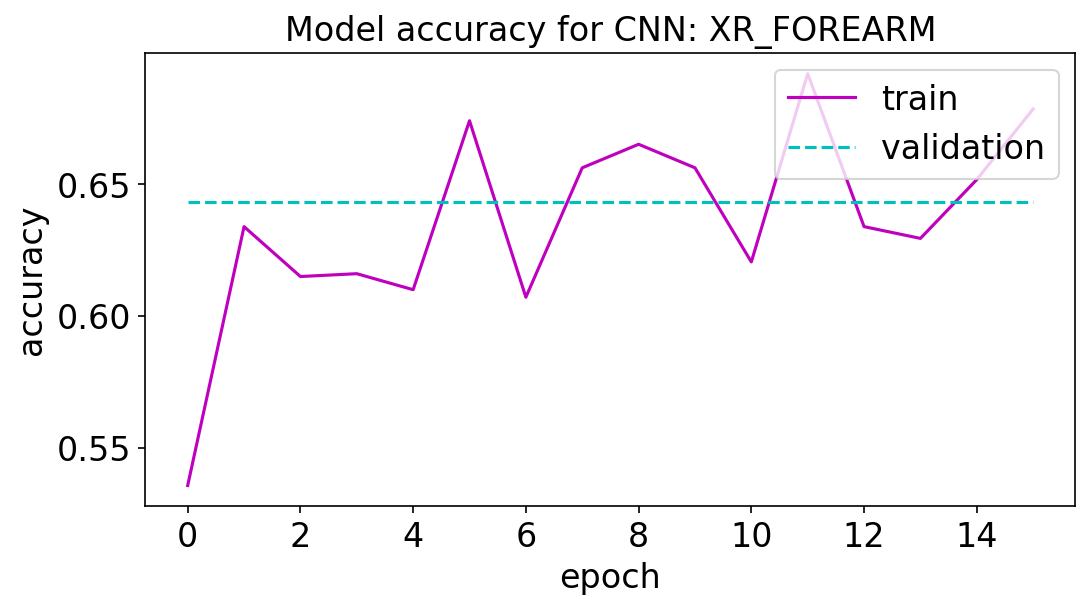

<Figure size 432x288 with 0 Axes>

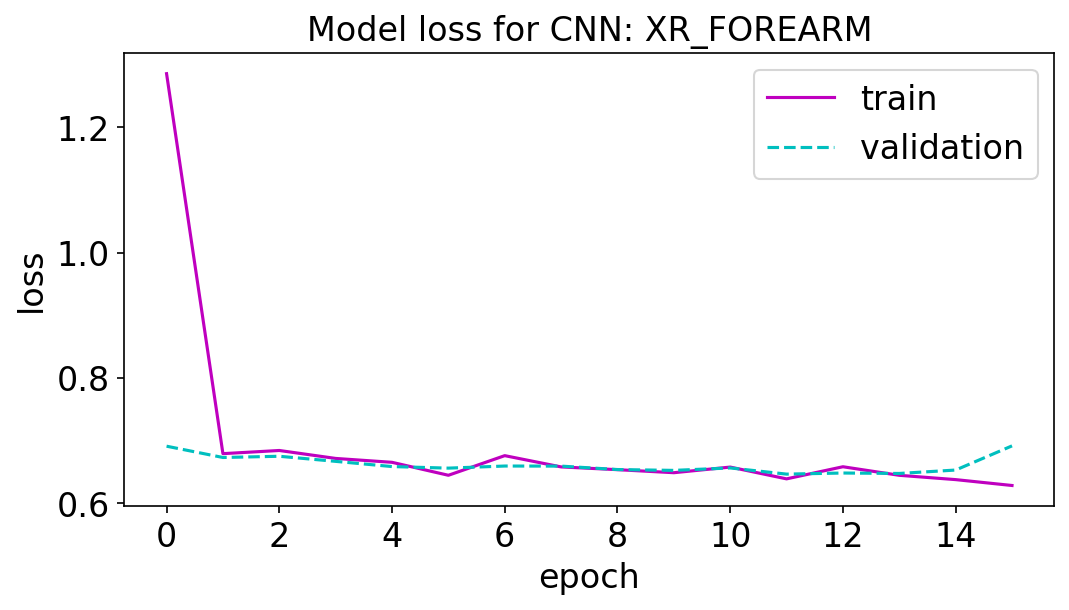

<Figure size 432x288 with 0 Axes>

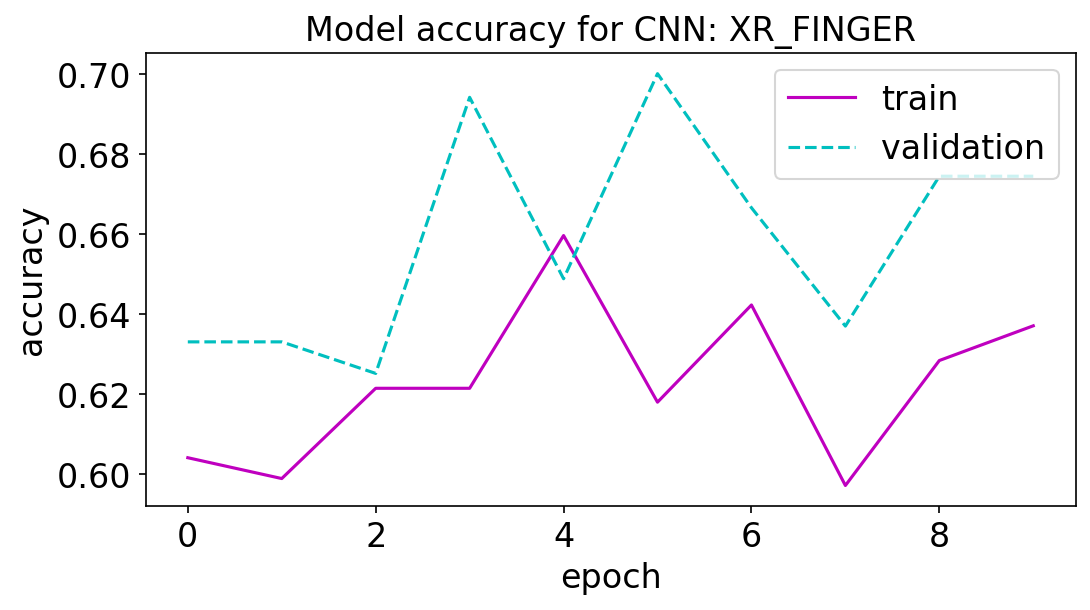

<Figure size 432x288 with 0 Axes>

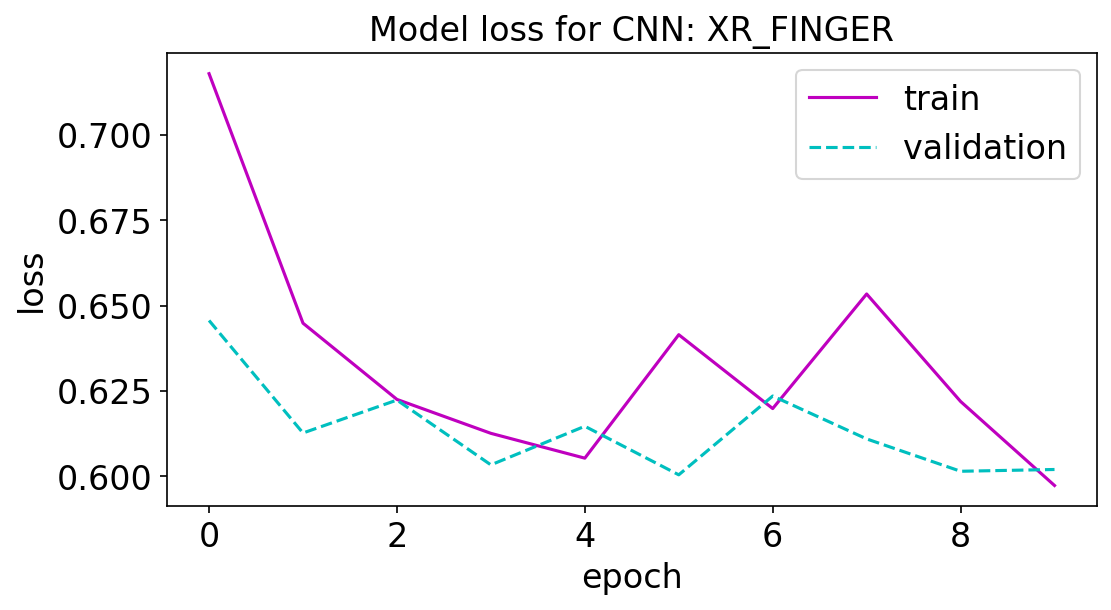

<Figure size 432x288 with 0 Axes>

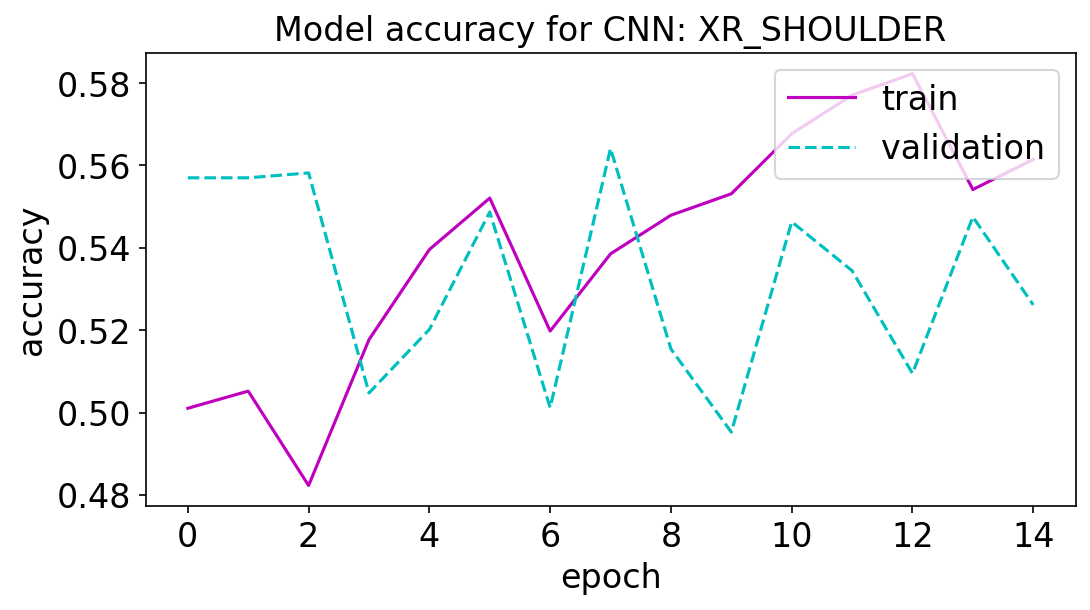

<Figure size 432x288 with 0 Axes>

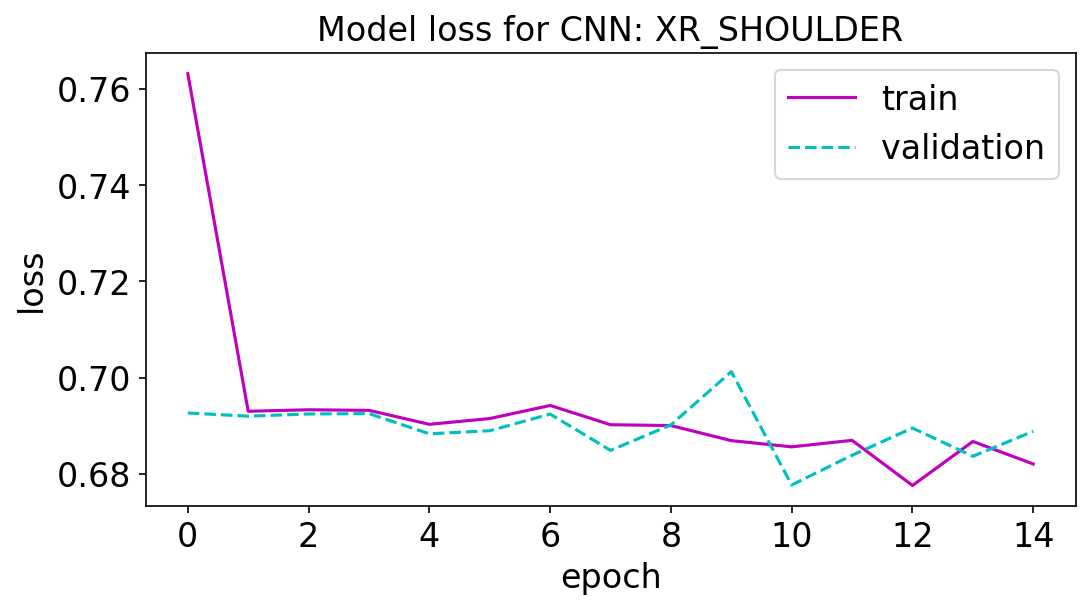

<Figure size 432x288 with 0 Axes>

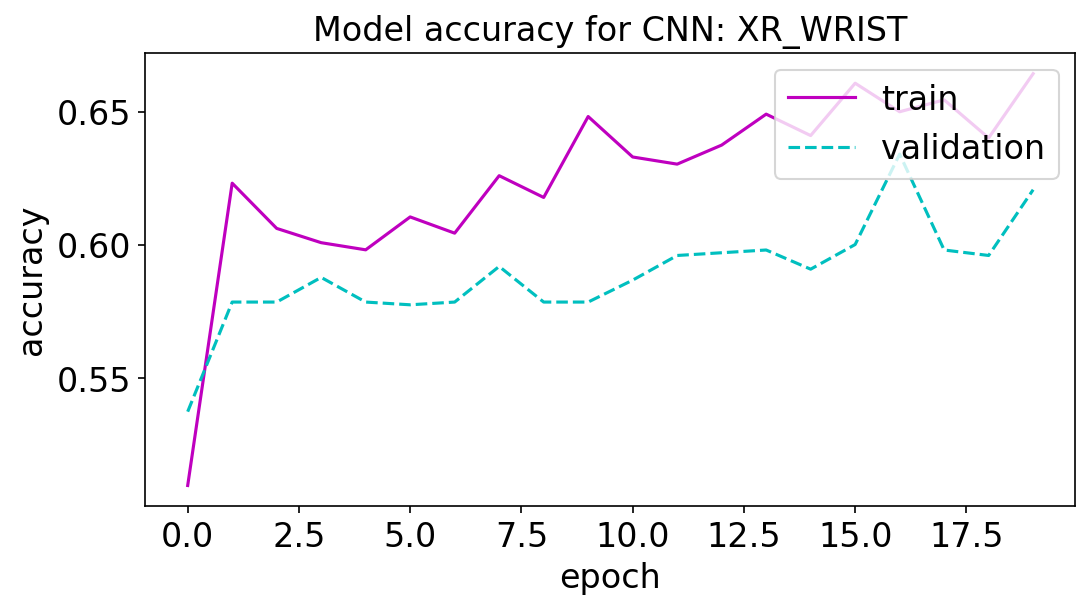

<Figure size 432x288 with 0 Axes>

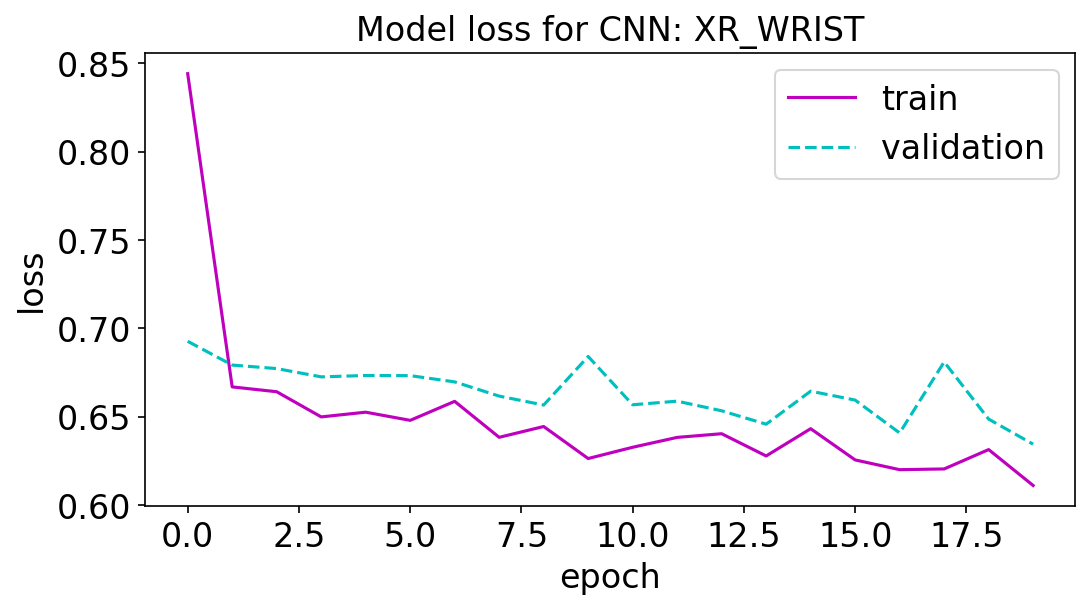

<Figure size 432x288 with 0 Axes>

In [10]:
import json
for bodypart in bodyparts:
    plot_learning_curves.plot_history(histories_cnn[bodypart], 
                                     bodypart,
                                     'base_model_',
                                     20,
                                     data_augmentation='deep_augment')

# CNN with pre-trained model

## DenseNet

### Build

In [ ]:
# add model on top
def build_model_on_densenet():
  # DenseNet model
  densenet_model = tf.keras.applications.DenseNet121(weights='imagenet',
                                                    input_shape = (320,320,3),
                                                    include_top = False)
  densenet_model.trainable = False
  # add new model on top
  inputs = tf.keras.Input(shape=(320,320,3))
  x = densenet_model(inputs, 
                    training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  # train the top layer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss = 'binary_crossentropy',
                metrics = ['binary_accuracy'])
  return model

In [ ]:
densenet_model_top = build_model_on_densenet()

### Train

In [ ]:
callbacks_2 = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                             patience=8,
                                             restore_best_weights=True)

def train_model(model, bodypart):
    validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
    print("Using validation_steps = %d" % validation_steps)
    steps_per_epoch = math.ceil(train_generators[bodypart].n / (train_generators[bodypart].batch_size))
    print("Using steps_per_epoch = %d" % steps_per_epoch)

    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=20,
                        verbose=1,
                        callbacks=[callbacks_2]
    )
    return history

In [ ]:
densenet_model_top_histories = {}
for bodypart in set(train.bodypart):
    print('-----------')
    print(bodypart)
    model = build_model_on_densenet()
    densenet_model_top_histories[bodypart] = train_model(model, 
                              bodypart)
    print('\nSave training history\n')
    with open("data/history/densenet_20epochs_deep_augment_"+bodypart+".json", "w") as file:
        json.dump(densenet_model_top_histories[bodypart].history, file)
        print('\nSave model\n')
    print('\nSave model\n')
    model.save("data/models/densenet_20epochs_deep_augment_"+bodypart)
    model.save("data/models/densenet_20epochs_deep_augment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    print('evaluate_test_generators')
    model.evaluate(test_generators[bodypart], verbose=1)
    print('evaluate_train_generators')
    model.evaluate(train_generators[bodypart], verbose=1)
    print('evaluate_valid_generators')
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

In [ ]:
for bodypart in bodyparts:
    plot_learning_curves.plot_history(densenet_model_top_histories[bodypart], 
                                     bodypart,
                                     'densenet',
                                     20,
                                     data_augmentation='deep_augment')

## Evaluate

In [36]:
from importlib import reload
reload(data_loader)

<module 'lib.data_loader' from '/tf/lib/data_loader.py'>

In [37]:
for bodypart in bodyparts:
    data_loader.load_evaluate_model(bodypart, 
                                "data/models/densenet_20epochs_deep_augment_"+bodypart+".h5", 
                                test, 
                                test_generators, 
                                train_generators, 
                                valid_generators)

XR_FOREARM Load model

Test accuracy: 49.83 %
Test F1 score: 0.0 %
Test Precision score: 0.0 %
Test Recall score: 0.0 %
test_loss:  69.59
test_acc:  49.83
train_acc:  63.91
valid_acc:  62.57
Delete model
XR_FINGER Load model

Test accuracy: 49.24 %
Test F1 score: 37.77 %
Test Precision score: 55.04 %
Test Recall score: 28.74 %
test_loss:  66.86
test_acc:  62.26
train_acc:  65.25
valid_acc:  71.65
Delete model
XR_HUMERUS Load model

Test accuracy: 51.39 %
Test F1 score: 0.0 %
Test Precision score: 0.0 %
Test Recall score: 0.0 %
test_loss:  69.11
test_acc:  51.39
train_acc:  51.88
valid_acc:  62.02
Delete model
XR_ELBOW Load model

Test accuracy: 50.54 %
Test F1 score: 0.0 %
Test Precision score: 0.0 %
Test Recall score: 0.0 %
test_loss:  69.26
test_acc:  50.54
train_acc:  59.09
valid_acc:  61.32
Delete model
XR_SHOULDER Load model

Test accuracy: 49.38 %
Test F1 score: 66.11 %
Test Precision score: 49.38 %
Test Recall score: 100.0 %
test_loss:  69.32
test_acc:  49.38
train_acc:  49.3
va

## ResNet152

### Build

In [ ]:
# add model on top
def build_model_on_resnet():
  # DenseNet model
  resnet_model = tf.keras.applications.resnet.ResNet152(weights='imagenet',
                                                        input_shape = (320,320,3),
                                                        include_top = False)
  resnet_model.trainable = False
  # add new model on top
  inputs = tf.keras.Input(shape=(320,320,3))
  x = resnet_model(inputs, 
                    training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  # train the top layer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss = 'binary_crossentropy',
                metrics = ['binary_accuracy'])
  return model

In [ ]:
resnet_model_top = build_model_on_resnet()

### Train

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=4,
                                             verbose=1)
validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
print("Using validation_steps = %d" % validation_steps)
steps_per_epoch = math.ceil(train_generators[bodypart].n / (8*train_generators[bodypart].batch_size))
print("Using steps_per_epoch = %d" % steps_per_epoch)
    
def train_model(model, bodypart):
    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=20,
                        verbose=1,
                        callbacks=[callbacks]
    )
    return history

In [ ]:
resnet_model_top_histories = {}
for bodypart in set(train.bodypart):
    print('-----------')
    print(bodypart)
    model = build_model_on_resnet()
    resnet_model_top_histories[bodypart] = train_model(model, 
                              bodypart)
    print('\nSave training history\n')
    with open("data/history/resnet_20epochs_deep_augment_"+bodypart+".json", "w") as file:
        json.dump(resnet_model_top_histories[bodypart].history, file)
        print('\nSave model\n')
    print('\nSave model\n')
    model.save("data/models/resnet_20epochs_deep_augment_"+bodypart)
    model.save("data/models/resnet_20epochs_deep_augment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    print('evaluate_test_generators')
    model.evaluate(test_generators[bodypart], verbose=1)
    print('evaluate_train_generators')
    model.evaluate(train_generators[bodypart], verbose=1)
    print('evaluate_valid_generators')
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

In [ ]:
for bodypart in bodyparts:
    plot_learning_curves.plot_history(resnet_model_top_histories[bodypart], 
                                     bodypart,
                                     'resnet_',
                                     20,
                                     data_augmentation='deep_augment')

## Evaluate

In [38]:
for bodypart in bodyparts:
    data_loader.load_evaluate_model(bodypart, 
                                "data/models/resnet_20epochs_deep_augment_"+bodypart+".h5", 
                                test, 
                                test_generators, 
                                train_generators, 
                                valid_generators)

XR_FOREARM Load model

Test accuracy: 48.5 %
Test F1 score: 17.11 %
Test Precision score: 44.44 %
Test Recall score: 10.6 %
test_loss:  68.65
test_acc:  59.14
train_acc:  67.44
valid_acc:  64.25
Delete model
XR_FINGER Load model

Test accuracy: 49.67 %
Test F1 score: 37.97 %
Test Precision score: 55.91 %
Test Recall score: 28.74 %
test_loss:  73.93
test_acc:  62.26
train_acc:  65.51
valid_acc:  68.5
Delete model
XR_HUMERUS Load model

Test accuracy: 50.35 %
Test F1 score: 44.79 %
Test Precision score: 48.74 %
Test Recall score: 41.43 %
test_loss:  63.85
test_acc:  66.32
train_acc:  68.07
valid_acc:  62.79
Delete model
XR_ELBOW Load model

Test accuracy: 50.11 %
Test F1 score: 12.12 %
Test Precision score: 47.06 %
Test Recall score: 6.96 %
test_loss:  69.01
test_acc:  54.41
train_acc:  60.42
valid_acc:  60.12
Delete model
XR_SHOULDER Load model

Test accuracy: 52.04 %
Test F1 score: 60.18 %
Test Precision score: 51.0 %
Test Recall score: 73.38 %
test_loss:  69.35
test_acc:  51.33
train_